## Define fields

In [1]:
from josie.fluid.fields import FluidFields
from josie.fields import Fields

class SigmaFields(FluidFields):
    # Conservative
    rho = 0
    rhoU = 1
    rhoV = 2
    rhoY = 3
    rhoYw = 4
    rhoa = 5
    rhoz = 6
    
    # Auxiliary
    U = 7
    V = 8
    P = 9
    c = 10
    Y = 11
    w = 12
    alpha = 13
    z = 14
    p1 = 15
    p2 = 16

    
class SigmaConsFields(Fields):
    rho = 0
    rhoU = 1
    rhoV = 2
    rhoY = 3
    rhoYw = 4
    rhoa = 5
    rhoz = 6

## Define State

In [2]:
from josie.fluid.state import SingleFluidState
from josie.state import SubsetState

class SigmaConsState(SubsetState):
    full_state_fields = SigmaFields
    fields = SigmaConsFields
    
class SigmaState(SingleFluidState):
    fields = SigmaFields
    cons_state = SigmaConsState
    


## Define Barotropic EOS

In [3]:
class Barotropic:
    """
    .. math::
    
        \pressure = a\rho^b
    """
    
    def __init__(self, a, b):
        self._constant = a
        self._exp = b
    
    def p(self, rho):
        return self._constant * rho ** self._exp
    
    def rho(self, p):
        return (p / self._constant) ** (1/self._exp)
    
    def sound_velocity(self, rho, p):
        return self._constant * self._exp * rho ** (self._exp - 1)

## Define Mixture EOS

In [4]:
from josie.twofluid.state import PhasePair

class MixtureEOS(PhasePair):
    def __init__(self, eos1, eos2, surface_tension):
        super().__init__(eos1, eos2)
        self.surface_tension = surface_tension

## Define Problem

In [5]:
import numpy as np

from josie.problem import Problem
from josie.dimension import MAX_DIMENSIONALITY
from josie.math import Direction

class SigmaProblem(Problem):
    
    # Small scale inertia
    sqrtm = np.sqrt(1)
    
    def __init__(self, eos: MixtureEOS):
        self.eos = eos
        
    def s(self, cells, t):
        values = cells.values.view(SigmaState)
        fields = values.fields
        nx, ny, num_dofs, _ = values.shape
        
        rhoYw = values[..., fields.rhoYw]
        p1 = values[..., fields.p1]
        p2 = values[..., fields.p2]
        
        
        # Store source
        ss = np.zeros_like(values)
        
        ss[..., fields.rhoa] = - rhoYw / self.sqrtm
        ss[..., fields.rhoYw] = (p2 - p1)/self.sqrtm
        
        return ss
        
        
    def F(self, values: SigmaState):
        nx, ny, num_dofs, _ = values.shape
        
        # Flux tensor
        F = np.zeros(
            (
                nx,
                ny,
                num_dofs,
                len(SigmaConsFields),
                MAX_DIMENSIONALITY,
            )
        )
        
        fields = values.view(SigmaState).fields
                  
        rho = values[..., fields.rho]
        rhoU = values[..., fields.rhoU]
        rhoV = values[..., fields.rhoV]
        rhoY = values[..., fields.rhoY]
        rhoYw = values[..., fields.rhoYw]
        rhoa = values[..., fields.rhoa]
        rhoz = values[..., fields.rhoz]
        
        U = values[..., fields.U]
        V = values[..., fields.V]
        P = values[..., fields.P]
        
       
        F[..., fields.rho, Direction.X] = rhoU
        F[..., fields.rho, Direction.Y] = rhoV
        F[..., fields.rhoU, Direction.X] = rhoU * U + P
        F[..., fields.rhoU, Direction.Y] = rhoU * V
        F[..., fields.rhoV, Direction.X] = rhoV * U
        F[..., fields.rhoV, Direction.Y] = rhoV * V + P
        F[..., fields.rhoY, Direction.X] = rhoY * U
        F[..., fields.rhoY, Direction.Y] = rhoY * V
        F[..., fields.rhoYw, Direction.X] = rhoYw * U
        F[..., fields.rhoYw, Direction.Y] = rhoYw * V
        F[..., fields.rhoa, Direction.X] = rhoa * U
        F[..., fields.rhoa, Direction.Y] = rhoa * V
        F[..., fields.rhoz, Direction.X] = rhoz * U
        F[..., fields.rhoz, Direction.Y] = rhoz * V
        
        return F
        
        

## Define Scheme

In [6]:
import numpy as cp

from josie.scheme.convective import ConvectiveScheme
from josie.twofluid.fields import Phases

class SigmaScheme(ConvectiveScheme):
    def __init__(self, eos: MixtureEOS):
        super().__init__(SigmaProblem(eos))
        
    def post_step(self, values: SigmaState):
        fields = values.view(SigmaState).fields
        
        rho = values[..., fields.rho]
        rhoU = values[..., fields.rhoU]
        rhoV = values[..., fields.rhoV]
        rhoY = values[..., fields.rhoY]
        rhoYw = values[..., fields.rhoYw]
        rhoa = values[..., fields.rhoa]
        rhoz = values[..., fields.rhoz]
        
        U = rhoU / rho
        V = rhoV / rho
        Y = rhoY / rho
        Y2 = 1 - Y
        w = rhoYw / rho / Y
        alpha = rhoa / rho
        alpha2 = 1 - alpha
        z = rhoz / rho
        Sigma = (rho ** (1/3)) * (z ** (2/3))
        
        surface_tension = self.problem.eos.surface_tension
        
        eos1 = self.problem.eos[Phases.PHASE1]
        rho1 = rho * Y / alpha
        p1 = eos1.p(rho1)
        c1 = eos1.sound_velocity(rho1, p1)
        
        
        rho2 = rho * Y2 / alpha2 
        eos2 = self.problem.eos[Phases.PHASE2]
        p2 = eos2.p(rho2)
        c2 = eos2.sound_velocity(rho1, p1)
        
        P = alpha * p1 + alpha2 * p2 + 0.5 * rhoYw**2 \
            - 2/3 * surface_tension * Sigma
        
        c = cp.sqrt(Y * c1**2 + Y2 * c2**2  + rho * (Y * w)**2 \
            + 2/9 * surface_tension * Sigma / rho)
               
        values[..., fields.U] = U
        values[..., fields.V] = V
        values[..., fields.P] = P
        values[..., fields.c] = c
        values[..., fields.Y] = Y
        values[..., fields.w] = w
        values[..., fields.alpha] = alpha
        values[..., fields.z] = z
        values[..., fields.p1] = p1
        values[..., fields.p2] = p2

## Rusanov Scheme

In [7]:
from josie.euler.schemes import Rusanov as EulerRusanov
from josie.general.schemes.time import ExplicitEuler
from josie.general.schemes.source import ConstantSource
from josie.general.schemes.space.muscl import MUSCL_Hancock
from josie.general.schemes.space.limiters import MinMod



class Rusanov(SigmaScheme, ExplicitEuler, ConstantSource):
    @staticmethod
    def compute_U_norm(values: SigmaState, normals):
        fields = values.view(SigmaState).fields

        # Get the velocity components
        UV_slice = slice(fields.U, fields.V + 1)
        UV = values[..., cp.newaxis, UV_slice]

        # Find the normal velocity
        U = cp.einsum("...mkl,...l->...mk", UV, normals)

        return U

    def CFL(self, cells, CFL_value):

        #dt = super().CFL(cells, CFL_value)

        values = cells.values.view(SigmaState)
        fields = values.fields

        # Get the velocity components
        UV_slice = slice(fields.U, fields.V + 1)
        UV = cells.values[..., UV_slice]

        U = cp.linalg.norm(UV, axis=-1, keepdims=True)
        c = cells.values[..., fields.c]

        sigma = cp.max(cp.abs(U) + c[..., cp.newaxis])

        # Min mesh dx
        dx = cells.min_length

        new_dt = CFL_value * dx / sigma

        #return cp.min((dt, new_dt))
        return new_dt
    
    @staticmethod
    def compute_sigma(U_L, U_R, c_L, c_R):

        sigma_L = cp.abs(U_L) + c_L[..., cp.newaxis]

        sigma_R = cp.abs(U_R) + c_R[..., cp.newaxis]

        # Concatenate everything in a single array
        sigma_array = cp.concatenate((sigma_L, sigma_R), axis=-1)

        # And the we found the max on the last axis (i.e. the maximum value
        # of sigma for each cell)
        sigma = cp.max(sigma_array, axis=-1, keepdims=True)

        return sigma

    def intercellFlux(
        self, Q_L: SigmaState, Q_R: SigmaState, normals: np.ndarray, surfaces: np.ndarray
    ) -> SigmaState:

        fields = SigmaState.fields

        FS = cp.zeros_like(Q_L).view(SigmaState)
        
        # Get normal velocities
        U_L = self.compute_U_norm(Q_L, normals)
        U_R = self.compute_U_norm(Q_R, normals)

        # Speed of sound
        c_L = Q_L[..., fields.c]
        c_R = Q_R[..., fields.c]

        sigma = self.compute_sigma(U_L, U_R, c_L, c_R)
        
        DeltaF = 0.5 * (self.problem.F(Q_L) + self.problem.F(Q_R))

        # This is the flux tensor dot the normal
        DeltaF = cp.einsum("...mkl,...l->...mk", DeltaF, normals)

        # First four variables of the total state are the conservative
        # variables
        Q_L_cons = Q_L.view(SigmaState).get_conservative()
        Q_R_cons = Q_R.view(SigmaState).get_conservative()

        DeltaQ = 0.5 * sigma * (Q_R_cons - Q_L_cons)

        FS.set_conservative(
            surfaces[..., cp.newaxis, cp.newaxis] * (DeltaF - DeltaQ)
        )

        return FS
    
class FinalScheme(
        Rusanov,
        MUSCL_Hancock, MinMod,
    ):
        pass

## Define Solver

In [8]:
from josie.solver import Solver

class SigmaSolver(Solver):
    def __init__(self, mesh, scheme):

        super().__init__(mesh, SigmaState, scheme)


## Define BCs

In [9]:
import numpy as np
from josie.bc import Dirichlet, Neumann, make_periodic

    
# Shortcut to define all Neumann conditions for everything except 
# vertical velocity
Q0 = np.zeros(len(SigmaFields)).view(SigmaState)
zero_normal_velocity = Neumann(Q0)

# We override the bc for rhoV and V
zero_normal_velocity.bc[..., [SigmaFields.rhoV, SigmaFields.V]] = \
    Dirichlet(0)

## Prepare the Domain

In [10]:
from josie.boundary import Line
from josie.math import Direction

left = Line([0, 0], [0, 1])
bottom = Line([0, 0], [1, 0])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])

# Left-right is periodic
left, right = make_periodic(left, right, Direction.X)

# Top-bottom
top.bc = zero_normal_velocity
bottom.bc = zero_normal_velocity

## Generate the Mesh

In [11]:
from josie.mesh import Mesh
from josie.mesh.cell import SimpleCell

mesh = Mesh(left, bottom, right, top, SimpleCell)
mesh.interpolate(150, 150)
mesh.generate()

## EOS

In [12]:
eos1 = Barotropic(a=1, b=1.4)
eos2 = Barotropic(a=1, b=1.67)

## Initial Conditions

In [13]:
# General
P = 0.71
speed = 0.25

l = 0.05 # Reference length for the interface initial thickness
We = 100 # Weber number



# Top value
alpha = 0.8
alpha2 = 1 - alpha
w = 0
U = -speed
V = 0
z = 0
p1 = p2 = P
rho1 = eos1.rho(p1)
c1 = eos1.sound_velocity(rho1, p1)

rho2 = eos2.rho(p2)
c2 = eos2.sound_velocity(rho2, p2)

rho = alpha * rho1 + (1 - alpha) * rho2
Sigma = (rho ** (1/3)) * (z ** (2/3))
Y = rho1 * alpha / rho
Y2 = 1 - Y




rhoU = rho * U
rhoV = rho * V
rhoY = rho * Y
rhoYw = rho * Y * w
rhoa = rho * alpha
rhoz = rho * z

# EOS
surface_tension = rho * speed**2 / We

eos = MixtureEOS(eos1, eos2, surface_tension=0)

c = np.sqrt(Y * c1**2 + Y2 * c2**2  + rho * (Y * w)**2 \
            - 2/9 * eos.surface_tension * Sigma / rho)

Q_top = SigmaState(rho, rhoU, rhoV, rhoY, rhoYw, rhoa, rhoz,
                   U, V, P, c, Y, w, alpha, z, p1, p2)

# Btm value
alpha = 0.2
alpha2 = 1 - alpha
w = 0
U = speed
V = 0
z = 0
p1 = p2 = P
rho1 = eos1.rho(p1)
c1 = eos1.sound_velocity(rho1, p1)

rho2 = eos2.rho(p2)
c2 = eos2.sound_velocity(rho2, p2)

rho = alpha * rho1 + (1 - alpha) * rho2
Sigma = (rho ** (1/3)) * (z ** (2/3))
Y = rho1 * alpha / rho
Y2 = 1 - Y




rhoU = rho * U
rhoV = rho * V
rhoY = rho * Y
rhoYw = rho * Y * w
rhoa = rho * alpha
rhoz = rho * z

c = np.sqrt(Y * c1**2 + Y2 * c2**2  + rho * (Y * w)**2 \
            - 2/9 * eos.surface_tension * Sigma / rho)


Q_btm = SigmaState(rho, rhoU, rhoV, rhoY, rhoYw, rhoa, rhoz,
                   U, V, P, c, Y, w, alpha, z, p1, p2)

# Interface value
alpha = 0.5
alpha2 = 1 - alpha
w = 0
U = 0
V = 0
z = 1e-2

p1 = p2 = P
rho1 = eos1.rho(p1)
c1 = eos1.sound_velocity(rho1, p1)

rho2 = eos2.rho(p2)
c2 = eos2.sound_velocity(rho2, p2)

rho = alpha * rho1 + (1 - alpha) * rho2
Sigma = (rho ** (1/3)) * (z ** (2/3))

Y = rho1 * alpha / rho
Y2 = 1 - Y


rhoU = rho * U
rhoV = rho * V
rhoY = rho * Y
rhoYw = rho * Y * w
rhoa = rho * alpha
rhoz = rho * z

c = np.sqrt(Y * c1**2 + Y2 * c2**2  + rho * (Y * w)**2 \
            - 2/9 * eos.surface_tension * Sigma / rho)


Q_int = SigmaState(rho, rhoU, rhoV, rhoY, rhoYw, rhoa, rhoz,
                   U, V, P, c, Y, w, alpha, z, p1, p2)

def interface(x):
    """The curve defining the interface"""
    
    y = 0.5 * np.ones_like(x)
    
    # xa, xb are the interval where to put the perturbation
    xa = 0.65
    xb = 0.85
    K = 0.03
    
    # Perturbation
  
    idx_pert = np.where((x >= xa) & (x <= xb))
    y[idx_pert] += K * np.sin(np.pi * ((x[idx_pert] - xa)/(xb - xa)))
    
    return y


def init_fun(cells):
    # First set everything to the interface value
    cells.values = Q_int
    
    dx = cells.min_length
    xc = cells.centroids[..., 0]
    yc = cells.centroids[..., 1]
    
    # Interface midline
    y_int = interface(xc)
    
    idx_top = np.where(yc > (y_int + dx))
    idx_btm = np.where(yc < (y_int - dx))

    
    # Change the value in the various part of the domain
    cells.values[idx_top[0], idx_top[1], ...] = Q_top
    cells.values[idx_btm[0], idx_btm[1], ...] = Q_btm

## Initialize

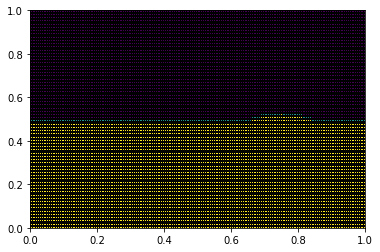

In [14]:
from josie.io.write.writer import XDMFWriter
from josie.io.write.strategy import TimeStrategy

# Instantiate the solver
solver = SigmaSolver(mesh, FinalScheme(eos))
solver.init(init_fun)

solver.plot()
solver.show("rho")

## Logging

In [15]:
import logging
from datetime import datetime

now = datetime.now().strftime('%Y%m%d%H%M%S')

logger = logging.getLogger("josie")
logger.setLevel(logging.DEBUG)

fh = logging.FileHandler(f"sigma-{now}.log")
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)

logger.addHandler(fh)

In [ ]:

# Write strategy
strategy = TimeStrategy(dt_save=0.1, animate=False)
writer = XDMFWriter(f"sigma-{now}.xdmf", strategy, solver, 
                    final_time=5, CFL=0.5)

writer.solve()

/var/folders/jq/xw5g5cn92_x68gwfg8krm8m80000gn/T/ipykernel_21380/1453061573.py:21: RuntimeWarning: invalid value encountered in true_divide
  U = rhoU / rho
/var/folders/jq/xw5g5cn92_x68gwfg8krm8m80000gn/T/ipykernel_21380/1453061573.py:22: RuntimeWarning: invalid value encountered in true_divide
  V = rhoV / rho
/var/folders/jq/xw5g5cn92_x68gwfg8krm8m80000gn/T/ipykernel_21380/1453061573.py:23: RuntimeWarning: invalid value encountered in true_divide
  Y = rhoY / rho
/var/folders/jq/xw5g5cn92_x68gwfg8krm8m80000gn/T/ipykernel_21380/1453061573.py:25: RuntimeWarning: invalid value encountered in true_divide
  w = rhoYw / rho / Y
/var/folders/jq/xw5g5cn92_x68gwfg8krm8m80000gn/T/ipykernel_21380/1453061573.py:26: RuntimeWarning: invalid value encountered in true_divide
  alpha = rhoa / rho
/var/folders/jq/xw5g5cn92_x68gwfg8krm8m80000gn/T/ipykernel_21380/1453061573.py:28: RuntimeWarning: invalid value encountered in true_divide
  z = rhoz / rho
